In [1]:
import geopandas as gpd
from udtk import geo, viz
import contextily as ctx
import matplotlib.pyplot as plt
%matplotlib inline

/home/pipe/urbansim/udtk/venv/lib/python3.7/site-packages/pysal-2.1.0-py3.7.egg/pysal/explore/segregation/network/network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"
/home/pipe/urbansim/udtk/venv/lib/python3.7/site-packages/pysal-2.1.0-py3.7.egg/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
#load original data
carto = gpd.read_file('../carto/nyc_parcels.geojson')

In [ ]:
f,ax = plt.subplots(figsize=(8,8))
carto.plot(ax=ax, alpha=0.1,markersize=0.2)

In [ ]:
#create grid
grid = geo.hexgrid_from_shapefile(input_shapefile='../carto/nyc_parcels.geojson',
                                  output_shapefile='../carto/grid_8',
                                  res = 8)

In [ ]:
#plot hexgrid data
f,ax = plt.subplots(figsize=(8,8))
grid.plot(ax=ax)

In [ ]:
grid.head()

In [ ]:
w = geo.weights_matrix(grid_id_name = 'h3_index',
                       input_shapefile = '../carto/grid_8/grid_8.shp',
                      output_pickle = '../data/w_8.pickle')

In [ ]:
cell_id = '882a100883fffff'

In [ ]:
w[cell_id]

In [ ]:
f,ax = plt.subplots(figsize=(8,8))
grid.plot(ax=ax)
grid.loc[grid.h3_index == cell_id].plot(ax=ax,color='red')
grid.loc[grid.h3_index.isin(w[cell_id].keys())].plot(ax=ax,color='green')

# Add several h3 resolutions to a table


In [3]:
carto_latlon = carto.to_crs(epsg=4326)
carto_latlon['x'] = carto_latlon.geometry.x
carto_latlon['y'] = carto_latlon.geometry.y

In [4]:
resolutions =  [8,9,10,11]
aggregation_dict = {'RetailArea':'mean','NumBldgs':'sum'}
aggregation_cols = ['h3_res_'+str(res) for res in resolutions ]

In [5]:
%time carto_latlon = geo.h3_indexing(carto_latlon.copy(), res =resolutions)

CPU times: user 4.63 s, sys: 48.1 ms, total: 4.68 s
Wall time: 4.68 s


In [6]:
%time gdf_list = [geo.aggregate_data(carto_latlon,aggregation_col,aggregation_dict) for aggregation_col in aggregation_cols]

CPU times: user 533 ms, sys: 3.67 ms, total: 537 ms
Wall time: 535 ms


/home/pipe/urbansim/udtk/venv/lib/python3.7/site-packages/pysal-2.1.0-py3.7.egg/pysal/viz/mapclassify/classifiers.py:138: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/home/pipe/urbansim/udtk/venv/lib/python3.7/site-packages/pysal-2.1.0-py3.7.egg/pysal/viz/mapclassify/classifiers.py:140: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % k_q, UserWarning)


[None, None, None, None]

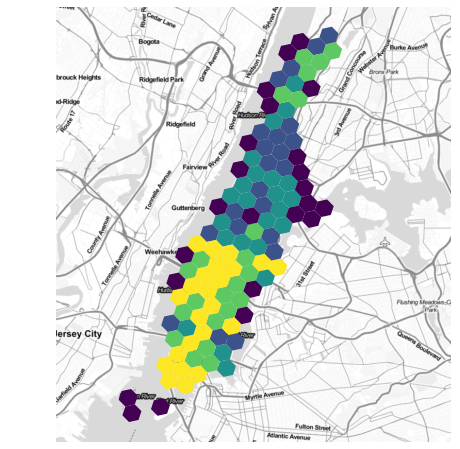

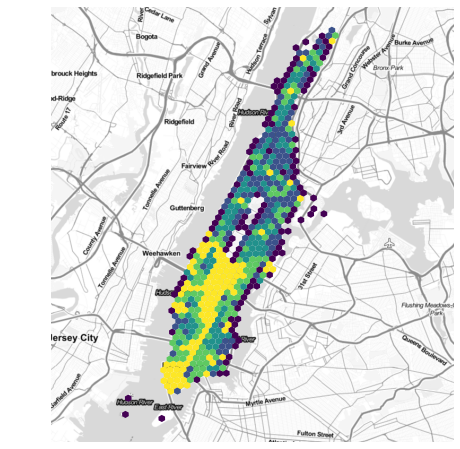

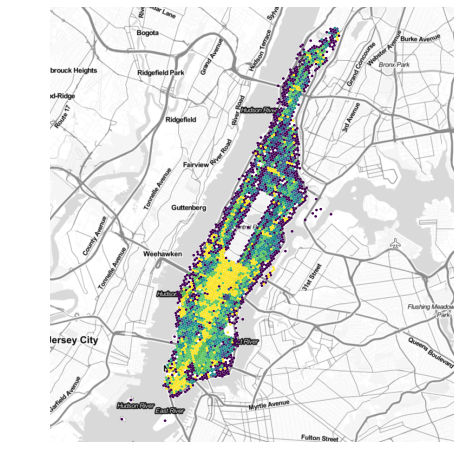

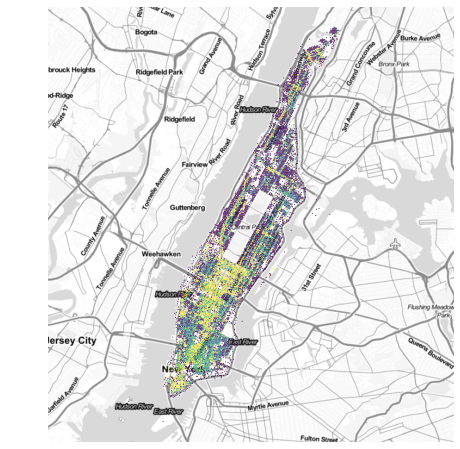

In [7]:
[viz.plot_h3_gdf(gdf_list[i],list(aggregation_dict.keys())[0]) for i in range(len(gdf_list))]